In [ ]:
# import necessary libraries

import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import model_selection, metrics
from collections import Counter
import matplotlib.pyplot as plt
import re

In [ ]:
# Loading both the datasets into two different data frames
df = pd.read_csv('/content/drive/MyDrive/MSML641_PROJECT/wcpr_mypersonality.csv', encoding='mac-roman' )
test_df = pd.read_csv('/content/drive/MyDrive/MSML641_PROJECT/wcpr_essays.csv', encoding = 'mac-roman')

#changing the columns names so that they are consistent with the training dataset
test_df.columns = ['#AUTHID', 'STATUS',	'cEXT',	'cNEU',	'cAGR',	'cCON',	'cOPN']

In [ ]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'NETWORKSIZE', 'BETWEENNESS',
       'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'],
      dtype='object')

In [ ]:
# Copying the data frame only with necessary columns for our purpose
df_new = df[['#AUTHID', 'STATUS', 'cEXT', 'cAGR', 'cCON', 'cOPN', 'cNEU']].copy()

# combining the data frames  
joint_df = pd.concat([df_new, test_df])

In [ ]:
df_new

,#AUTHID,STATUS,cEXT,cAGR,cCON,cOPN,cNEU
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,n,n,n,y,y
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,n,n,n,y,y
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,n,n,n,y,y
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,n,n,n,y,y
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,n,n,n,y,y
...,...,...,...,...,...,...,...
9912,deb899e426c1a5c66c24eeb0d7df6257,little things give you away.,n,y,n,y,n
9913,ea28a927cb6663480ea33ca917c3c8ba,is wishing it was Saturday.,y,y,y,y,y
9914,ea28a927cb6663480ea33ca917c3c8ba,is studying hard for the G.R.E.,y,y,y,y,y
9915,5532642937eb3497a43e15dbb23a9d2d,snipers get more head,n,n,n,y,y


In [ ]:
# Total no. of users
df_new['#AUTHID'].nunique()

250

In [ ]:
# function to load the stop words
def load_stopwords(filename):
    stopwords = [] 
    with open(filename, "r") as f:
        words = f.read()
        words = words.split('\n')
        stopwords = words
    return set(stopwords)

stopwords = load_stopwords('/content/drive/MyDrive/MSML641_PROJECT/mallet_en_stoplist.txt')


In [ ]:
# getting the encoder for encoding test labels into numericals
encoder = LabelEncoder()


# function to preprocess the text data
def preprocess_text(text, stopwords = stopwords):
  # for word in stopwords:
  #   if word in text:
  #     text = re.sub(word, "", text)
  #     text = re.sub("  ", " ", text)
  text = text.lower()
  # text = re.sub("[^A-Za-z]", " ", text)
  # text = re.sub("  ", " ", text)
  
  return text

# function to filter the stopwords from text 
def filter_stop_words_from_text(text_series):
  text_series.apply(preprocess_text)
  return text_series


# function to split the data 
def split_training_set(features, labels, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, stratify=labels)
    return X_train, X_test, y_train, y_test

# function to split the data frame into X and y for training and testing
def get_features_and_labels(dataframe):
  feature_list = ['#AUTHID', 'STATUS', 'cEXT', 'cAGR', 'cCON', 'cOPN']
  label_list = ['cNEU']
  return (dataframe[feature_list], dataframe[label_list])

# function to convert the text labels into binary for training and testing
def convert_categorical_features_to_numeric(features, encoder):
  feature_AUTHID = list(features['#AUTHID'])
  feature_STATUS = list(features['STATUS'])
  feature_cEXT = encoder.fit_transform(features['cEXT'].ravel())
  feature_cAGR = encoder.fit_transform(features['cAGR'].ravel())
  feature_cCON = encoder.fit_transform(features['cCON'].ravel())
  feature_cOPN = encoder.fit_transform(features['cOPN'].ravel())

  zipped = list(zip(feature_AUTHID, feature_STATUS, feature_cEXT, feature_cAGR, feature_cCON, feature_cOPN))

  return pd.DataFrame(zipped, columns = ['#AUTHID', 'STATUS', 'cEXT', 'cAGR', 'cCON', 'cOPN'])


# function to get user level accuracy instead of post level accuracy
def get_user_level_predictions(classifier, X , y , threshold = 0.8):
  userids = X['#AUTHID']
  predictions = classifier.predict((X[['STATUS']], X[['cEXT', 'cAGR', 'cCON', 'cOPN']]))
  user_level_preds = {}
  for userid in set(list(userids)):
    for i in range(len(list(userids))):
      if userids[i] == userid:
        user_dict = user_level_preds.get(userid, {'cum_preds': 0, 'no_preds': 0, 'final_pred': None})
        user_dict['cum_preds'] += predictions[i] 
        user_dict['no_preds'] += 1
        user_level_preds[userid] = user_dict

  for user in user_level_preds.keys():
    if user_level_preds[user]['cum_preds']/float(user_level_preds[user]['no_preds']) >= threshold:
      user_level_preds[user]['final_pred'] = 'y'
    else:
      user_level_preds[user]['final_pred'] = 'n'
    
  return dict(zip(user_level_preds.keys(), [user_level_preds[key]['final_pred'] for key in user_level_preds.keys()]))

# function to get user label from post labels
def get_user_level_labels(df):
  labels_df = pd.DataFrame(df[['#AUTHID', 'cNEU']])
  labels_df.drop_duplicates()
  userids = list(labels_df['#AUTHID'])
  labels = list(labels_df['cNEU'])
  return dict(zip(userids, labels))


# function to get user level accuracy
def get_user_level_accuracy(user_labels, user_preds):
  n = len(user_labels.keys())
  sum = 0
  for key in user_preds.keys():
    if user_labels[key] == user_preds[key]:
      sum+= 1
  accuracy = sum/float(n)
  return accuracy

In [ ]:
# spliting X and y from the training and testing datasets
train_X, train_y = get_features_and_labels(joint_df)
train_X, dev_X, train_y, dev_y = split_training_set(train_X, train_y, test_size=0.2)
train_X, test_X, train_y, test_y = split_training_set(train_X, train_y, test_size=0.2)

In [ ]:
# Encoding text labels to numeric labels
train_y = encoder.fit_transform(np.array(train_y).ravel()).reshape((-1,1))
test_y = encoder.fit_transform(np.array(test_y).ravel()).reshape((-1,1))
dev_y = encoder.fit_transform(np.array(dev_y).ravel()).reshape((-1,1))

In [ ]:
# converting the test features into binary features
train_X = convert_categorical_features_to_numeric(train_X, encoder)
test_X = convert_categorical_features_to_numeric(test_X, encoder)
dev_X = convert_categorical_features_to_numeric(dev_X, encoder)

In [ ]:
# filtering the stop words from the text part of the data
train_X['STATUS'] = filter_stop_words_from_text(train_X['STATUS'])
test_X['STATUS'] = filter_stop_words_from_text(test_X['STATUS'])
dev_X['STATUS'] = filter_stop_words_from_text(dev_X['STATUS'])

In [ ]:
# unit tests to check whether the number of features and labels are consistent for training and testing datasets
assert train_X.shape[0], train_y.shape[0]
assert test_X.shape[0], test_y.shape[0]

print(f"The number of training samples {train_y.shape[0]}")
print(f"The number of testing samples {test_y.shape[0]}")

The number of training samples 7926
The number of testing samples 1982


In [ ]:
# Constants 

NUM_FOLDS = 5

In [ ]:
# storing the link to the embedding layer in a handle
model_handle = "https://tfhub.dev/google/nnlm-en-dim128/2"

In [ ]:
# This function defines the architecture of the model
def build_model(handle = model_handle):

  combined_input = tf.keras.layers.Input(shape = (5,))

  text_input = tf.keras.layers.Input(dtype=tf.string, shape=())
  categorical_input = tf.keras.layers.Input(shape=(4,))

  embeddings = hub.KerasLayer(handle, input_shape=[], dtype=tf.string)(text_input)
  text_intermediate = keras.layers.Dense(16, activation='relu')(embeddings)
  x = tf.keras.layers.Dropout(0.2)(text_intermediate)
  x = tf.keras.layers.BatchNormalization()(x)
  text_output = keras.layers.Dense(1, activation='leaky_relu')(x)

  combined = tf.keras.layers.Concatenate(axis = 1)([text_output, categorical_input])
  combined_intermediate = tf.keras.layers.Dense(16, activation= 'relu')(combined)
  x = tf.keras.layers.Dropout(0.2)(combined_intermediate)
  x = tf.keras.layers.BatchNormalization()(x)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

  model = tf.keras.models.Model(inputs=[text_input, categorical_input], outputs=output)
  
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 128)          124642688   ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 16)           2064        ['keras_layer[0][0]']            
                                                                                                  
 dropout (Dropout)              (None, 16)           0           ['dense[0][0]']                  
                                                                                              

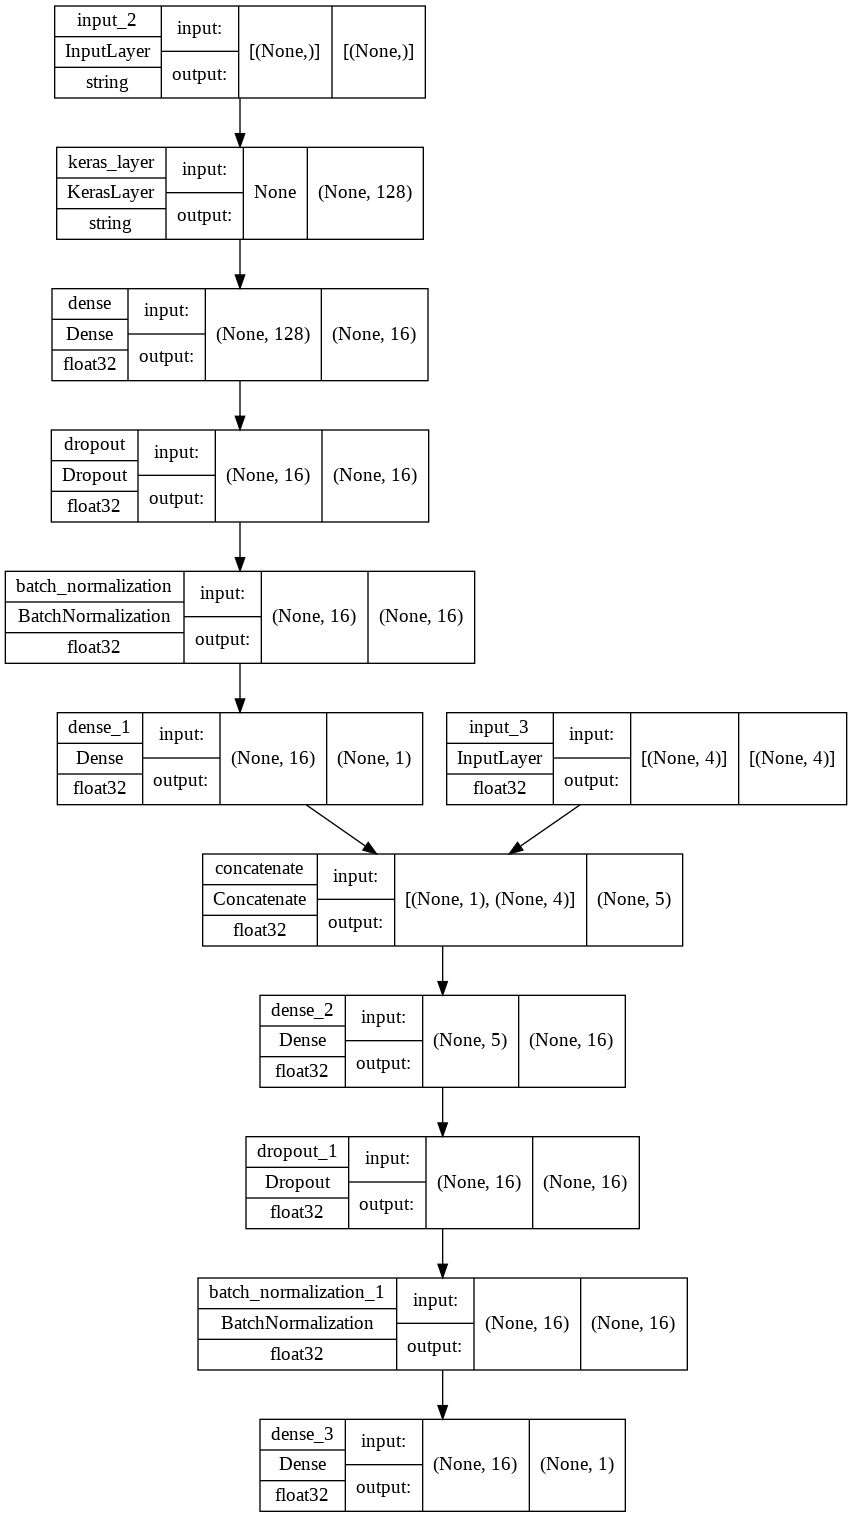

In [ ]:
# building the model
model = build_model()
model.summary()

# plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
%%time
# training the model
history = model.fit(x = (train_X[['STATUS']], train_X[['cEXT', 'cAGR', 'cCON', 'cOPN']]), 
          y = train_y,
          batch_size = 32,
          validation_data = ( (dev_X[['STATUS']], dev_X[['cEXT', 'cAGR', 'cCON', 'cOPN']]), dev_y ),
          epochs = 20)

Epoch 1/20
248/248 [==============================] - 6s 14ms/step - loss: 0.6986 - accuracy: 0.6355 - val_loss: 0.6017 - val_accuracy: 0.6811
Epoch 2/20
248/248 [==============================] - 3s 11ms/step - loss: 0.6152 - accuracy: 0.6721 - val_loss: 0.5842 - val_accuracy: 0.6952
Epoch 3/20
248/248 [==============================] - 3s 12ms/step - loss: 0.6026 - accuracy: 0.6809 - val_loss: 0.5811 - val_accuracy: 0.7017
Epoch 4/20
248/248 [==============================] - 2s 9ms/step - loss: 0.5945 - accuracy: 0.6903 - val_loss: 0.5786 - val_accuracy: 0.7037
Epoch 5/20
248/248 [==============================] - 2s 9ms/step - loss: 0.5915 - accuracy: 0.6882 - val_loss: 0.5748 - val_accuracy: 0.7004
Epoch 6/20
248/248 [==============================] - 2s 9ms/step - loss: 0.5832 - accuracy: 0.7002 - val_loss: 0.5711 - val_accuracy: 0.7061
Epoch 7/20
248/248 [==============================] - 3s 11ms/step - loss: 0.5787 - accuracy: 0.7020 - val_loss: 0.5723 - val_accuracy: 0.7041
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


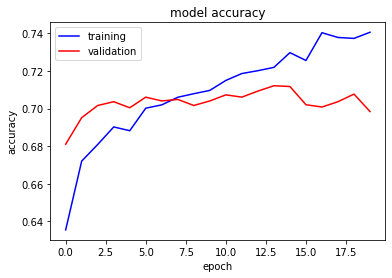

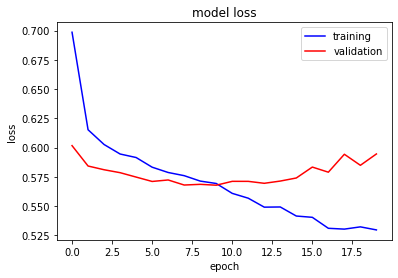

In [ ]:
# plots


print(history.history.keys())

plt.plot(history.history['accuracy'], 'b', label = 'training')
plt.plot(history.history['val_accuracy'], 'r', label = 'validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], 'b', label = 'training')
plt.plot(history.history['val_loss'], 'r', label = 'validation')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# evaluating the model
model.evaluate(x = (test_X[['STATUS']], test_X[['cEXT', 'cAGR', 'cCON', 'cOPN']]), 
               y = test_y)

62/62 [==============================] - 0s 3ms/step - loss: 0.5701 - accuracy: 0.7230


[0.5700661540031433, 0.723007082939148]

In [ ]:
# The names of evauation metrics shown above
model.metrics_names

['loss', 'accuracy']

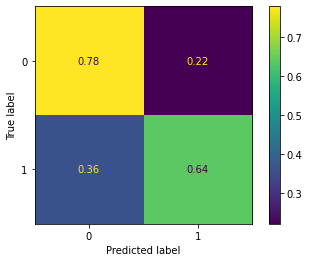

In [ ]:
# plotting the confusion matrix on the test data
predicted_labels = (model.predict((test_X[['STATUS']], test_X[['cEXT', 'cAGR', 'cCON', 'cOPN']])) > 0.5) * 1
ConfusionMatrixDisplay.from_predictions(test_y, predicted_labels, normalize = 'true')
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [ ]:
# getting various metrics on test data 
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  test_y)))
for label in [0, 1]:
  print('Precision for label {} = {}'.format('no', metrics.precision_score(predicted_labels, test_y, pos_label=label)))
  print('Recall    for label {} = {}'.format('yes', metrics.recall_score(predicted_labels,    test_y, pos_label=label)))

Accuracy  = 0.7230070635721494
Precision for label no = 0.7789915966386555
Recall    for label yes = 0.7642209398186315
Precision for label no = 0.6388888888888888
Recall    for label yes = 0.657997399219766
